In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('myplt.mplstyle')

from scipy import signal
from sklearn.linear_model import LinearRegression

path_pv = '../dataset/pv/20230309/continuous_1.gz'
path_or = '../dataset/orientation/20230309/continuous_1.gz'
data_pv = pd.read_csv(path_pv,
                      compression='gzip',
                      skiprows=6,
                      delimiter='\t',
                      header=None)
data_or = pd.read_csv(path_or,
                      compression='gzip',
                      skiprows=1,
                      delimiter='\t',
                      header=None)

pv_timestamp = data_pv[0][1:].to_numpy()
pv_fs = int(1/(pv_timestamp[1] - pv_timestamp[0]))

pv_c = data_pv[1][1:].to_numpy()
pv_b = data_pv[2][1:].to_numpy()
pv_tl = data_pv[3][1:].to_numpy()
pv_tr = data_pv[4][1:].to_numpy()

or_timestamp = ((data_or[0].to_numpy().astype(int))//10)*0.01
or_fs = int(1/(or_timestamp[1] - or_timestamp[0]))

or_y = data_or[1].to_numpy()
or_p = data_or[2].to_numpy()
or_r = data_or[3].to_numpy()

# or_y = np.where(or_y > 180, or_y - 360, or_y) # depend on the condition

In [80]:
def despike(arr, window_size, threshold):
    pad_size = window_size // 2
    arr_padded = np.pad(arr, pad_size, mode='reflect')
    arr_rolled = np.convolve(arr_padded, np.ones(window_size)/window_size, mode='same')
    spikes = np.abs(arr-arr_rolled[pad_size:-pad_size]) > threshold
    arr_despiked = np.copy(arr)
    arr_despiked[spikes] = arr_rolled[pad_size:-pad_size][spikes]
    return arr_despiked

def detrend(arr):
    x = np.arange(len(arr)).reshape(-1, 1)
    model = LinearRegression().fit(x, arr)
    trend = model.predict(x)
    detrended = arr - trend.flatten()
    return detrended

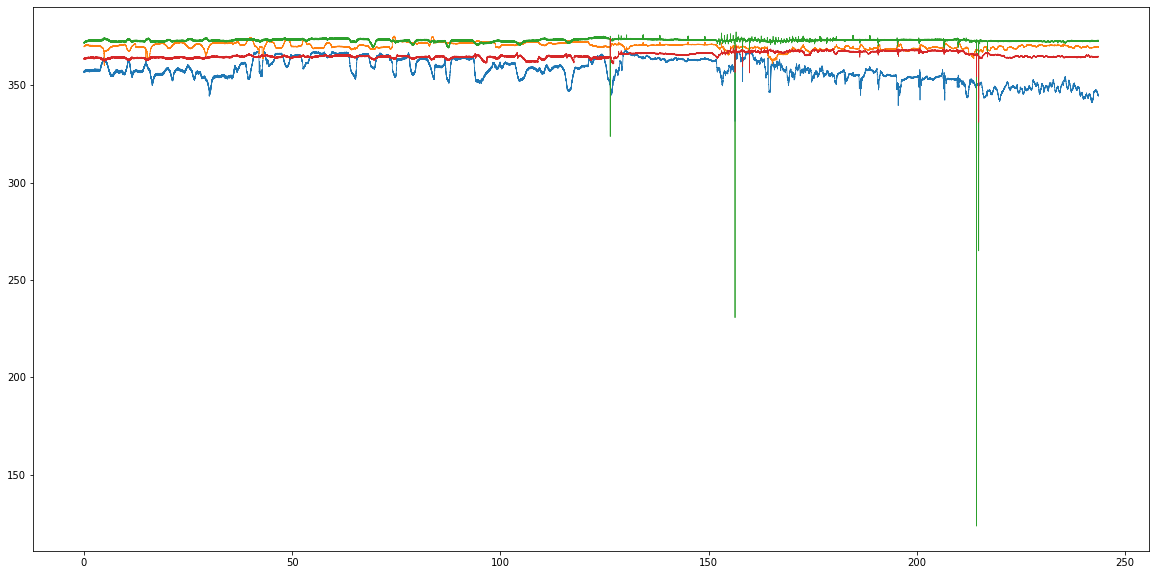

In [81]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot()
ax.plot(pv_timestamp, pv_c)
ax.plot(pv_timestamp, pv_b)
ax.plot(pv_timestamp, pv_tl)
ax.plot(pv_timestamp, pv_tr)

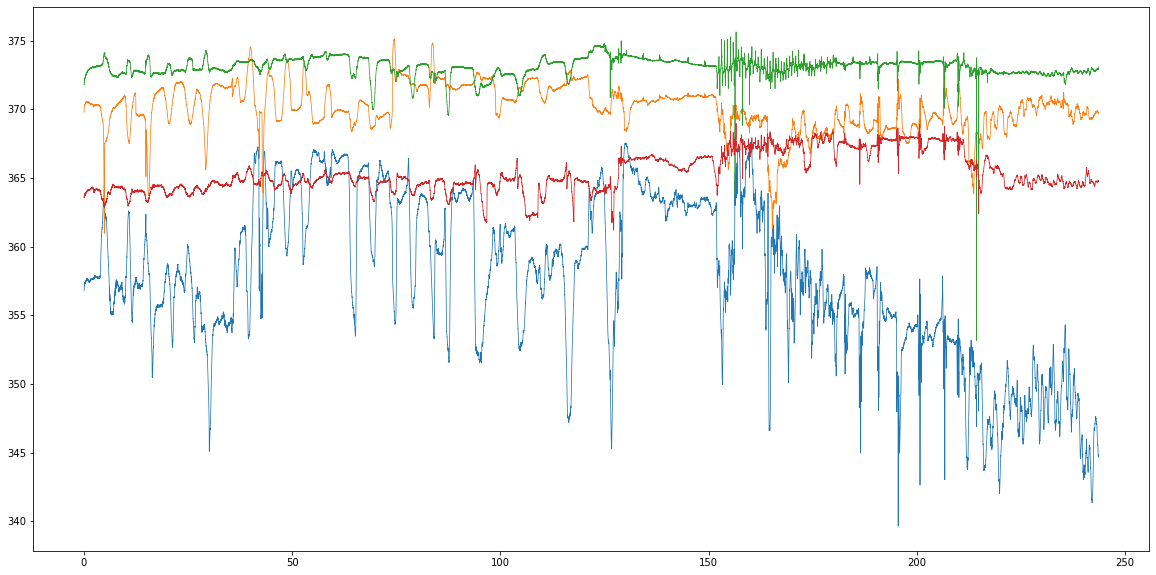

In [82]:
b, a = signal.butter(2, 30, fs=pv_fs)
pv_c_f = signal.filtfilt(b, a, pv_c)
pv_b_f = signal.filtfilt(b, a, pv_b)
pv_tl_f = signal.filtfilt(b, a, pv_tl)
pv_tr_f = signal.filtfilt(b, a, pv_tr)

fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot()
ax.plot(pv_timestamp, pv_c_f)
ax.plot(pv_timestamp, pv_b_f)
ax.plot(pv_timestamp, pv_tl_f)
ax.plot(pv_timestamp, pv_tr_f)


(200.0, 220.0)

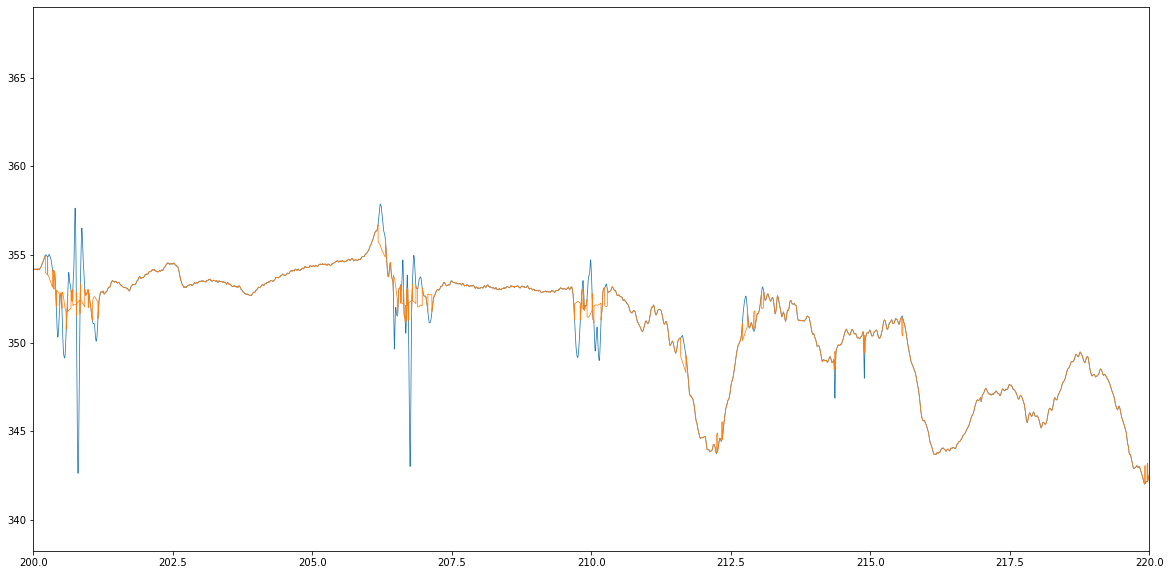

In [83]:
# for 20230309/continuous_2

pv_c_f_ds = despike(pv_c_f, 500, 1)
pv_tl_f_ds = despike(pv_tl_f, 500, 1)
pv_tr_f_ds = despike(pv_tr_f, 500, 1)
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot()
ax.plot(pv_timestamp, pv_c_f)
ax.plot(pv_timestamp, pv_c_f_ds)
ax.set_xlim(200, 220)

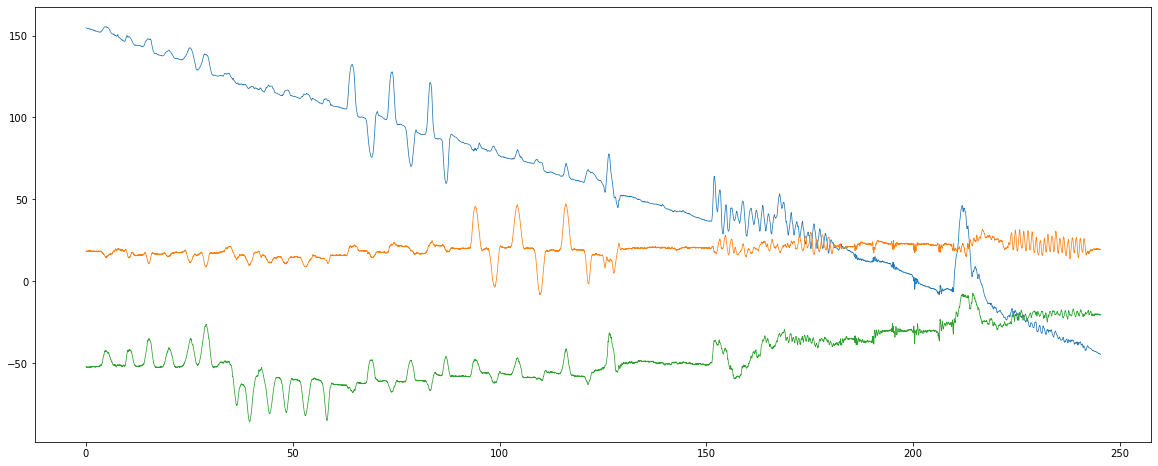

In [84]:
fig = plt.figure(figsize=[20, 8])
ax1 = fig.add_subplot()
ax1.plot(or_timestamp, or_y)
ax1.plot(or_timestamp, or_p)
ax1.plot(or_timestamp, or_r)

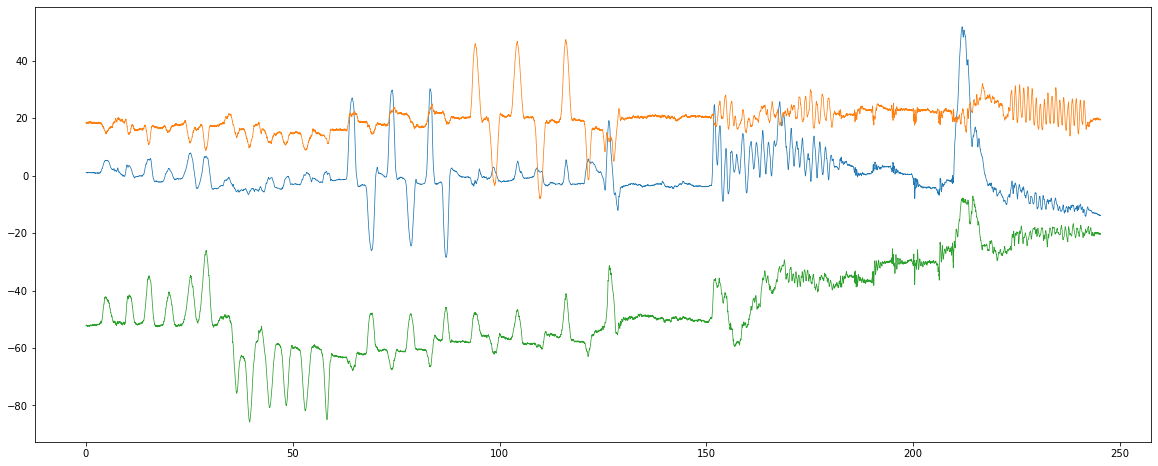

In [85]:
WINDOW = 100
THRESHOLD = 10

or_y_ds = despike(or_y, WINDOW, THRESHOLD)
or_y_dt = detrend(or_y_ds)

fig = plt.figure(figsize=[20, 8])
ax1 = fig.add_subplot()
ax1.plot(or_timestamp, or_y_dt)
ax1.plot(or_timestamp, or_p)
ax1.plot(or_timestamp, or_r)

FOR 20230309/continuous_1

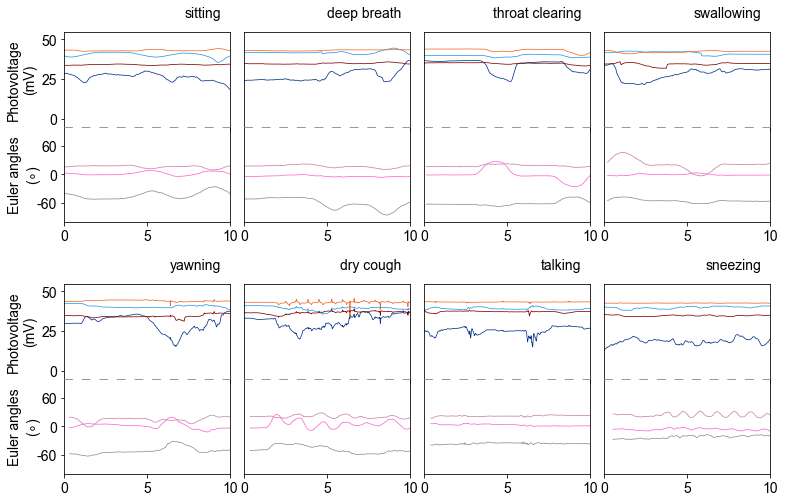

In [86]:
left_borders = np.array([20, 31, 60, 93, 120, 150, 180, 220])
right_borders = left_borders+10

labels = ['sitting',
          'deep breath',
          'throat clearing',
          'swallowing',
          'yawning',
          'dry cough',
          'talking',
          'sneezing']

plt.rc('lines', lw=0.75)
fig = plt.figure(figsize=[10, 7])
subfigs = fig.subfigures(nrows=2, ncols=4, wspace=0)
font = {'family': 'arial',
        'size': 14}
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']

isFirstInItsRow = False

for ii, (l, r, subfig) in enumerate(zip(left_borders, right_borders, subfigs.flatten())):
    if ii % 4 == 0: 
        isFirstInItsRow = True
    else:
        isFirstInItsRow = False
        
    sample_pv_ind = np.arange(l*pv_fs, r*pv_fs)
    sample_or_ind = np.arange(l*or_fs, r*or_fs)
    (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)
    ax2.spines['top'].set_linestyle((0, (10, 12)))
    ax2.spines['top'].set_color('gray')
    
    ax1.plot(pv_timestamp[sample_pv_ind], pv_c_f[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_b_f[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_tl_f[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_tr_f[sample_pv_ind])
    ax1.set_ylim([325, 385])
    if isFirstInItsRow:
        ax1.set_ylabel('Photovoltage\n(mV)', labelpad=4, fontdict=font)
        ax1.set_yticks([330, 355, 380])
        ax1.set_yticklabels([0, 25, 50], fontdict=font)
    else:
        ax1.set_yticks([])
    for jj, line in enumerate(ax1.get_lines()):
        line.set_color(pv_color[jj])

    ax2.plot(or_timestamp[sample_or_ind], or_y_dt[sample_or_ind])
    ax2.plot(or_timestamp[sample_or_ind], or_p[sample_or_ind])
    ax2.plot(or_timestamp[sample_or_ind], or_r[sample_or_ind])
    ax2.set_ylim([-100, 100])
    if isFirstInItsRow:
        ax2.set_ylabel('Euler angles\n($\circ$)', labelpad=-6, fontdict=font)
        ax2.set_yticks([-60, 0, 60])
        ax2.set_yticklabels([-60, 0, 60], fontdict=font)
    else:
        ax2.set_yticks([])
    ax2.set_xlim([l, r])
    ax2.set_xticks([l, (l+r)/2, r])
    ax2.set_xticklabels([0, 5, 10], fontdict=font)
    # ax2.set_xlabel('Time (s)', fontdict=font)
    for jj, line in enumerate(ax2.get_lines()):
        line.set_color(or_color[jj])
    
    subfig.suptitle(labels[ii], x=1, ha='right', fontproperties=font)
    plt.subplots_adjust(right=1.05,
                        hspace=0)        

plt.show()

FOR 20230309/continuous_2

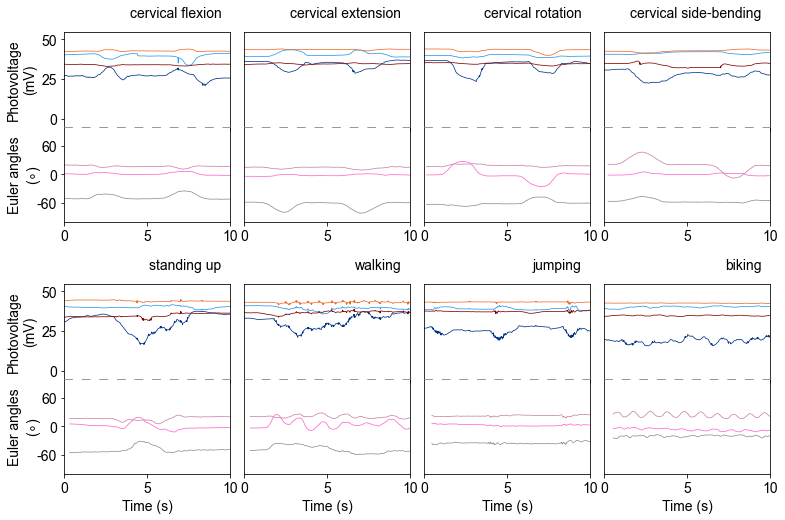

In [87]:
left_borders = np.array([8, 46, 62, 102, 122, 150, 182, 223])
right_borders = left_borders+10

labels = ['cervical flexion',
          'cervical extension',
          'cervical rotation',
          'cervical side-bending',
          'standing up',
          'walking',
          'jumping',
          'biking']

plt.rc('lines', lw=0.75)
fig = plt.figure(figsize=[10, 7])
subfigs = fig.subfigures(nrows=2, ncols=4, wspace=0)
font = {'family': 'arial',
        'size': 14}
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']

isFirstInItsRow = False
isLastInItsColumn = False

for ii, (l, r, subfig) in enumerate(zip(left_borders, right_borders, subfigs.flatten())):
    if ii % 4 == 0: 
        isFirstInItsRow = True
    else:
        isFirstInItsRow = False
    
    if ii // 4 != 0:
        isLastInItsColumn = True
    else:
        isLastInItsColumn = False
        
    sample_pv_ind = np.arange(l*pv_fs, r*pv_fs)
    sample_or_ind = np.arange(l*or_fs, r*or_fs)
    (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)
    ax2.spines['top'].set_linestyle((0, (10, 12)))
    ax2.spines['top'].set_color('gray')
    
    ax1.plot(pv_timestamp[sample_pv_ind], pv_c_f_ds[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_b_f[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_tl_f_ds[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_tr_f_ds[sample_pv_ind])
    ax1.set_ylim([325, 385])
    if isFirstInItsRow:
        ax1.set_ylabel('Photovoltage\n(mV)', labelpad=4, fontdict=font)
        ax1.set_yticks([330, 355, 380])
        ax1.set_yticklabels([0, 25, 50], fontdict=font)
    else:
        ax1.set_yticks([])
    for i, line in enumerate(ax1.get_lines()):
        line.set_color(pv_color[i])
    
    ax2.plot(or_timestamp[sample_or_ind], or_y_dt[sample_or_ind])
    ax2.plot(or_timestamp[sample_or_ind], or_p[sample_or_ind])
    ax2.plot(or_timestamp[sample_or_ind], or_r[sample_or_ind])
    ax2.set_ylim([-100, 100])
    if isFirstInItsRow:
        ax2.set_ylabel('Euler angles\n($\circ$)', labelpad=-6, fontdict=font)
        ax2.set_yticks([-60, 0, 60])
        ax2.set_yticklabels([-60, 0, 60], fontdict=font)
    else:
        ax2.set_yticks([])
    ax2.set_xlim([l, r])
    ax2.set_xticks([l, (l+r)/2, r])
    ax2.set_xticklabels([0, 5, 10], fontdict=font)
    if isLastInItsColumn:
        ax2.set_xlabel('Time (s)', fontdict=font)
    for i, line in enumerate(ax2.get_lines()):
        line.set_color(or_color[i])

    subfig.suptitle(labels[ii], x=1, ha='right', fontproperties=font)
    plt.subplots_adjust(right=1.05,
                        hspace=0)        

plt.show()

CONTINUOUS PLOT

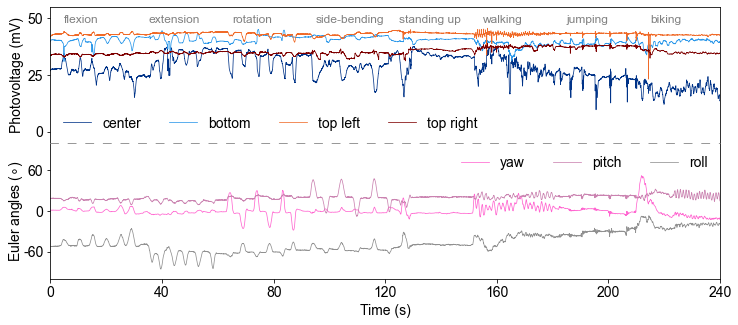

In [100]:
fig = plt.figure(figsize=[12, 5])
(ax1, ax2) = fig.subplots(nrows=2)
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')    

ax1.plot(pv_timestamp, pv_c_f, label='center')
ax1.plot(pv_timestamp, pv_b_f, label='bottom')
ax1.plot(pv_timestamp, pv_tl_f, label='top left')
ax1.plot(pv_timestamp, pv_tr_f, label='top right')

ax1.set_xlabel('Time (s)', fontdict=font)
ax1.set_xlim(0, 240)
ax1.set_xticks([])

ax1.set_ylabel('Photovoltage (mV)', labelpad=4, fontdict=font)
ax1.set_ylim([325, 385])
ax1.set_yticks([330, 355, 380])
ax1.set_yticklabels([0, 25, 50], fontdict=font)

for ii, line in enumerate(ax1.get_lines()):
    line.set_color(pv_color[ii])
ax1.legend(loc='lower left',
           ncol=len(ax1.get_lines()),
           frameon=False,
           prop=font)

ax1.text(5, 330+48, 'flexion', fontfamily='arial', size=12, color='gray')
ax1.text(35, 330+48, 'extension', fontfamily='arial', size=12, color='gray')
ax1.text(65, 330+48, 'rotation', fontfamily='arial', size=12, color='gray')
ax1.text(95, 330+48, 'side-bending', fontfamily='arial', size=12, color='gray')
ax1.text(125, 330+48, 'standing up', fontfamily='arial', size=12, color='gray')
ax1.text(155, 330+48, 'walking', fontfamily='arial', size=12, color='gray')
ax1.text(185, 330+48, 'jumping', fontfamily='arial', size=12, color='gray')
ax1.text(215, 330+48, 'biking', fontfamily='arial', size=12, color='gray')

ax2.plot(or_timestamp, or_y_dt, label='yaw')
ax2.plot(or_timestamp, or_p, label='pitch')
ax2.plot(or_timestamp, or_r, label='roll')

ax2.set_xlabel('Time (s)', fontdict=font)
ax2.set_xlim(0, 240)
ax2.set_xticks(np.arange(0, 280, 40))
ax2.set_xticklabels(np.arange(0, 280, 40), fontdict=font)

ax2.set_ylabel('Euler angles ($\circ$)', labelpad=-2, fontdict=font)
ax2.set_ylim([-100, 100])
ax2.set_yticks([-60, 0, 60])
ax2.set_yticklabels([-60, 0, 60], fontdict=font)

for ii, line in enumerate(ax2.get_lines()):
    line.set_color(or_color[ii])
ax2.legend(loc='upper right',
           ncol=len(ax2.get_lines()),
           frameon=False,
           prop=font)

plt.subplots_adjust(hspace=0)